 ## Setup and Imports:

In [1]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from diffusers import DDPMScheduler, UNet2DModel
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

############################
import matplotlib
import matplotlib.font_manager
from mpl_toolkits.axes_grid1 import make_axes_locatable

matplotlib.rcParams["figure.dpi"] = 300
matplotlib.rcParams["axes.linewidth"] = 2.5
from matplotlib import rc

rc("font", **{"family": "serif", "serif": ["Computer Modern Roman"], "size": 22})
rc("text", usetex=True)
############################

device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


/Users/jokeitm/miniconda3/envs/aibook-generative/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: mps


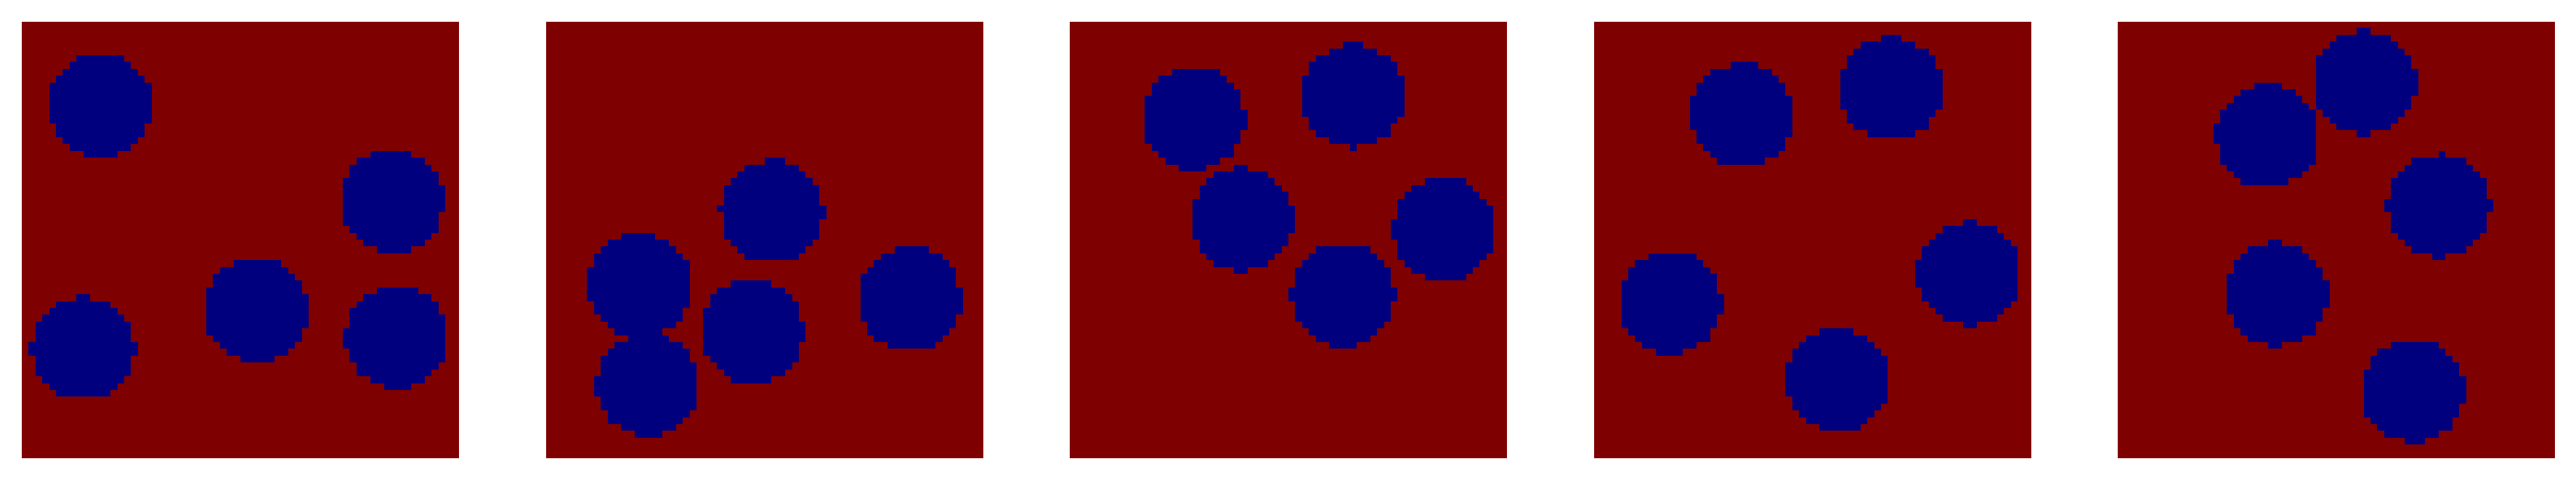

In [2]:
def generateNonOverlappingCirclesInDomain(N, domainLength, numberOfCircles, radius):
    domain = np.ones((N,N))
    x = np.linspace(0, domainLength, N)
    y = np.linspace(0, domainLength, N)
    x, y = np.meshgrid(x, y)
    
    for i in range(numberOfCircles):
        overlap = True
        while overlap == True:
            xc = np.random.uniform(radius, domainLength - radius)
            yc = np.random.uniform(radius, domainLength - radius)
            
            mask = (x - xc)**2 + (y - yc)**2 < radius**2
            if ~np.any(domain[mask] == 0):
                overlap = False
        domain[mask] = 0
    return domain

###############################################################################

N = 64
domainLength = 1
numberOfCircles = 5
radius = 0.12
min_max_side_length = (0.8, 0.8)

np.random.seed(0)

numberOfSamples = 12800 # 640? #1280
numberOfAnomolousSamples = 128
    
samples = torch.zeros((numberOfSamples, 1, N, N))
for i in range(numberOfSamples):
    samples[i, 0] = torch.from_numpy(generateNonOverlappingCirclesInDomain(N, domainLength, numberOfCircles, radius)).to(torch.float32)
torch.save(samples, f"data/normalData{N}.pt")

# Plot the first 5 generated microstructures
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    sample = samples[i].squeeze()
    ax.imshow(sample, cmap='jet')
    ax.axis('off')
plt.show()


In [3]:
class microstructureDataset(Dataset):
    def __init__(self, data, labels=None, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)
        
        if self.labels is None:
            return sample, 0
        else:
            label = self.labels[idx]
            return sample, label
    

data  = torch.load('data/normalData64.pt')
print(data.shape)
print(data.min(), data.max())

labels = torch.load('data/shapeLabels64.pt')
dataset = microstructureDataset(data[1:12800])
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)


torch.Size([12800, 1, 64, 64])
tensor(0.) tensor(1.)


Input shape: torch.Size([8, 1, 64, 64])
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0])


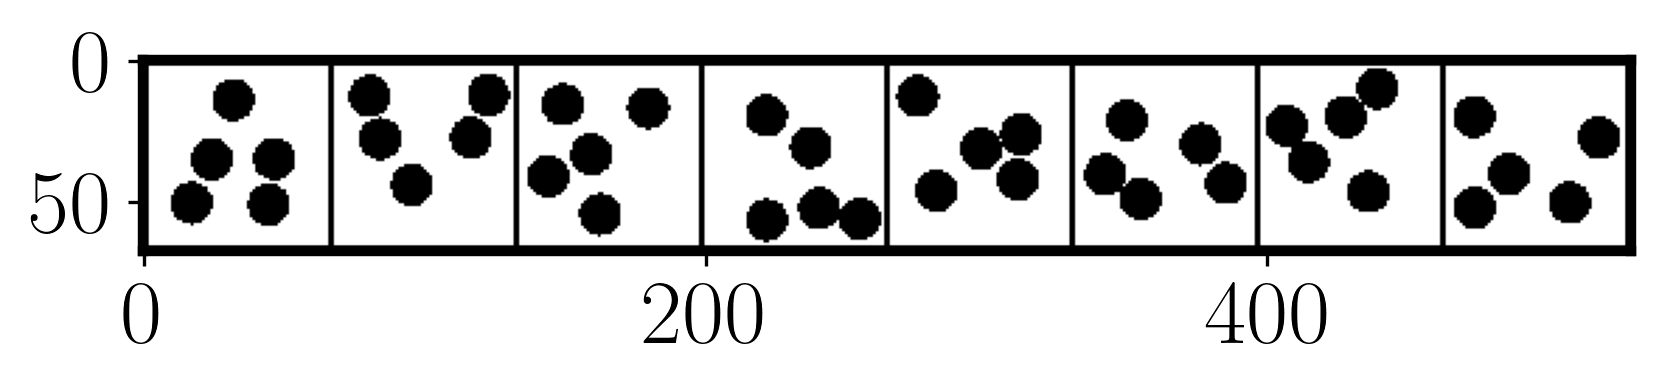

In [4]:
x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='grey')
plt.savefig('outputs/diffusion/sample.png')
plt.show()

N = x.shape[-1]


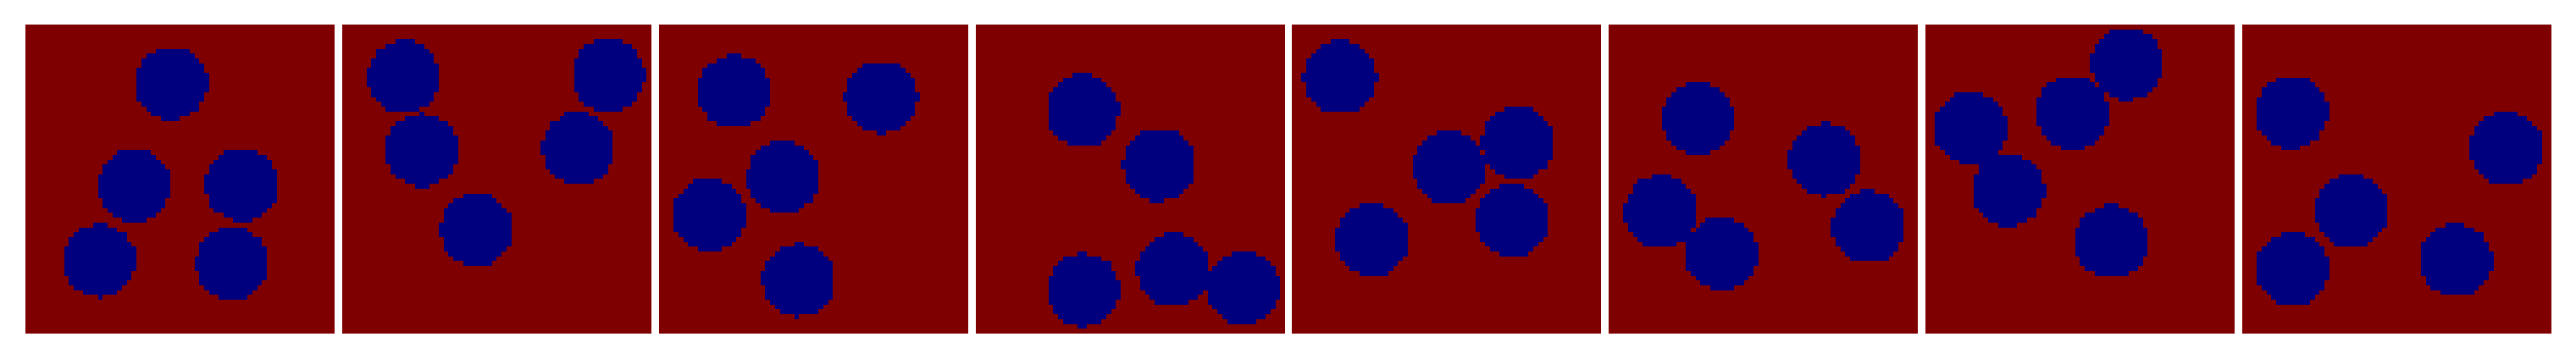

In [5]:
x = x.detach().cpu()
y = y.detach().cpu()

fig, axes = plt.subplots(1, 8 , figsize=(10, 1.5))

for i, ax in enumerate(axes):
    ax.imshow(x[i][0], cmap='jet')
    ax.axis('off')

# ax.set_rasterized(True)
fig.tight_layout(pad=0.1)
plt.savefig('outputs/diffusion/sample.pdf')
plt.show()

N = x.shape[-1]

In [6]:
def corrupt(x, amount):
  """Corrupt the input `x` by mixing it with noise according to `amount`"""
  noise = torch.rand_like(x)
  amount = amount.view(-1, 1, 1, 1) # Sort shape so broadcasting works
  return x*(1-amount) + noise*amount


tensor([0.0000, 0.1429, 0.2857, 0.4286, 0.5714, 0.7143, 0.8571, 1.0000])
['0', '1', '2', '3', '4', '5', '6', 'T']


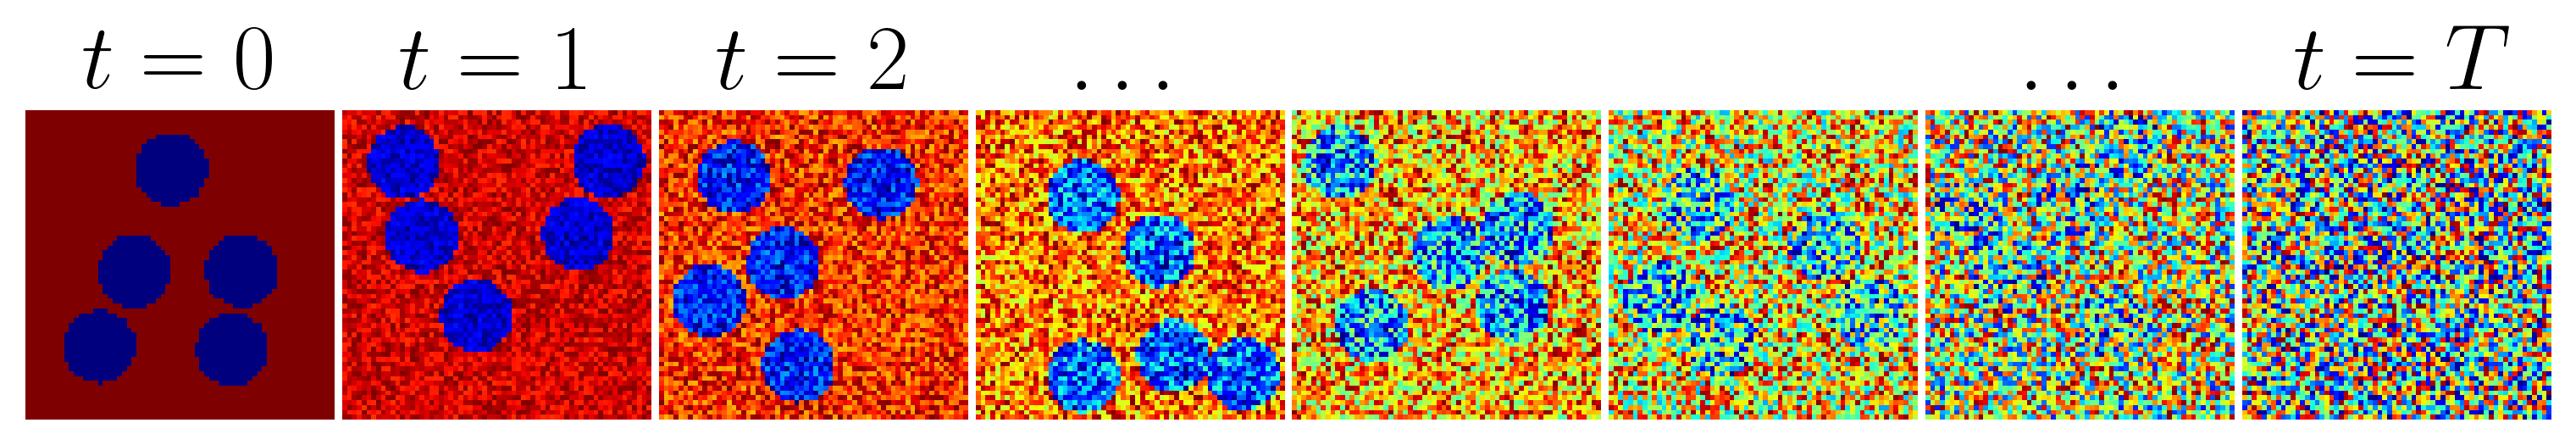

In [7]:
# Adding noise
amount = torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
noised_x = corrupt(x, amount)
print(amount)

t_labels = [f'{i}' for i in range(7)]
t_labels.append('T')
print(t_labels)

fig, axes = plt.subplots(1, 8, figsize=(10, 2))

for i in range(8):
    axes[i].imshow(noised_x[i][0], cmap='jet')
    axes[i].axis('off')

    # axes[i].set_title(f'$t = {t_labels[i]}$')

axes[0].set_title(r'$t = 0$')
axes[1].set_title(r'$t = 1$')
axes[2].set_title(r'$t = 2$')
axes[3].set_title(r'$\dots$')
axes[6].set_title(r'$\dots$')
axes[7].set_title(r'$t = T$')

# ax.set_rasterized(True)
plt.tight_layout(pad=0.1)
plt.savefig('outputs/diffusion/noisy_samples.pdf', bbox_inches='tight')
plt.savefig('outputs/diffusion/noisy_samples.pdf', bbox_inches='tight')
plt.show()

 As noise amount approaches one, our data begins to look like pure random noise. But for most noise amounts, you can guess the digit fairly well. Do you think this is optimal?

In [8]:
class BasicUNet(nn.Module):
    """A minimal UNet implementation."""
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down_layers = torch.nn.ModuleList([
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
        ])
        self.up_layers = torch.nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, out_channels, kernel_size=5, padding=2),
        ])
        self.act = nn.SiLU() # The activation function
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x)) # Through the layer and the activation function
            if i < 2: # For all but the third (final) down layer:
              h.append(x) # Storing output for skip connection
              x = self.downscale(x) # Downscale ready for the next layer

        for i, l in enumerate(self.up_layers):
            if i > 0: # For all except the first up layer
              x = self.upscale(x) # Upscale
              x += h.pop() # Fetching stored output (skip connection)
            x = self.act(l(x)) # Through the layer and the activation function

        return x


In [9]:
net = BasicUNet()
random_noise = torch.rand(8, 1, N, N)
print(random_noise.min(), random_noise.max())
net(random_noise).shape



tensor(3.7551e-06) tensor(1.0000)


torch.Size([8, 1, 64, 64])

In [10]:
sum([p.numel() for p in net.parameters()])


309057

Finished epoch 0. Average loss for this epoch: 0.097812
Finished epoch 1. Average loss for this epoch: 0.042192
Finished epoch 2. Average loss for this epoch: 0.036943
Finished epoch 3. Average loss for this epoch: 0.034180
Finished epoch 4. Average loss for this epoch: 0.030074
Finished epoch 5. Average loss for this epoch: 0.027687
Finished epoch 6. Average loss for this epoch: 0.026263
Finished epoch 7. Average loss for this epoch: 0.025429
Finished epoch 8. Average loss for this epoch: 0.024214
Finished epoch 9. Average loss for this epoch: 0.022756
Finished epoch 10. Average loss for this epoch: 0.022630
Finished epoch 11. Average loss for this epoch: 0.021896
Finished epoch 12. Average loss for this epoch: 0.021434
Finished epoch 13. Average loss for this epoch: 0.020685
Finished epoch 14. Average loss for this epoch: 0.020866
Finished epoch 15. Average loss for this epoch: 0.020900
Finished epoch 16. Average loss for this epoch: 0.020321
Finished epoch 17. Average loss for this 

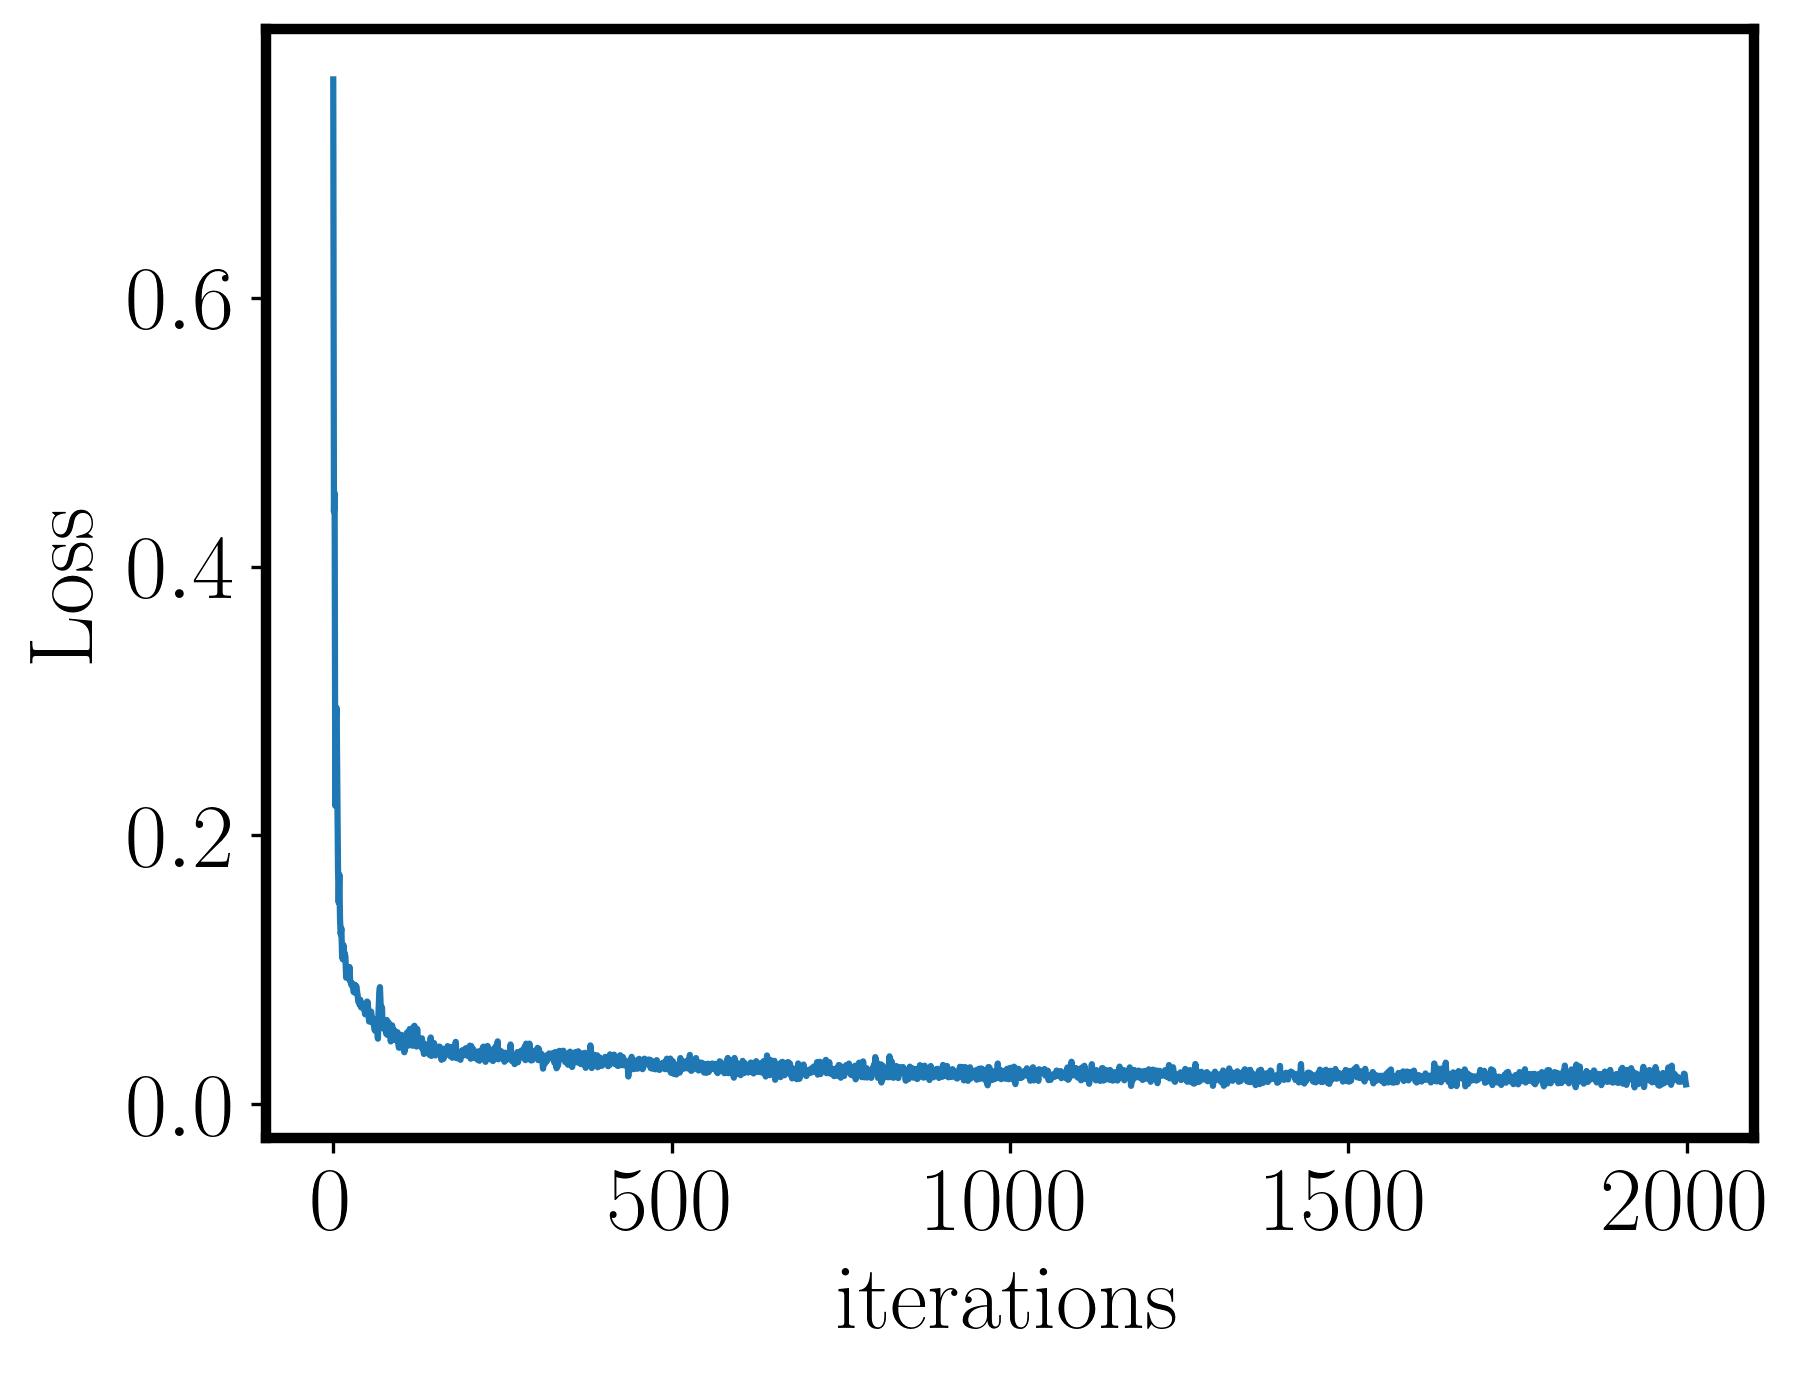

In [11]:
# Dataloader (you can mess with batch size)
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# How many runs through the data should we do?
n_epochs = 20

# Create the network
net = BasicUNet()
net.to(device)

# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):

    for x, y in train_dataloader:

        # Get some data and prepare the corrupted version
        x = x.to(device) # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device) # Pick random noise amounts
        noisy_x = corrupt(x, noise_amount) # Create our noisy x

        # Get the model prediction
        pred = net(noisy_x)

        # Calculate the loss
        loss = loss_fn(pred, x) # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')


# View the loss curve
plt.figure()
plt.plot(losses)
plt.xlabel("iterations")
plt.ylabel("Loss")
# plt.ylim(0, 1)
plt.savefig('outputs/diffusion/loss.png')
plt.show()


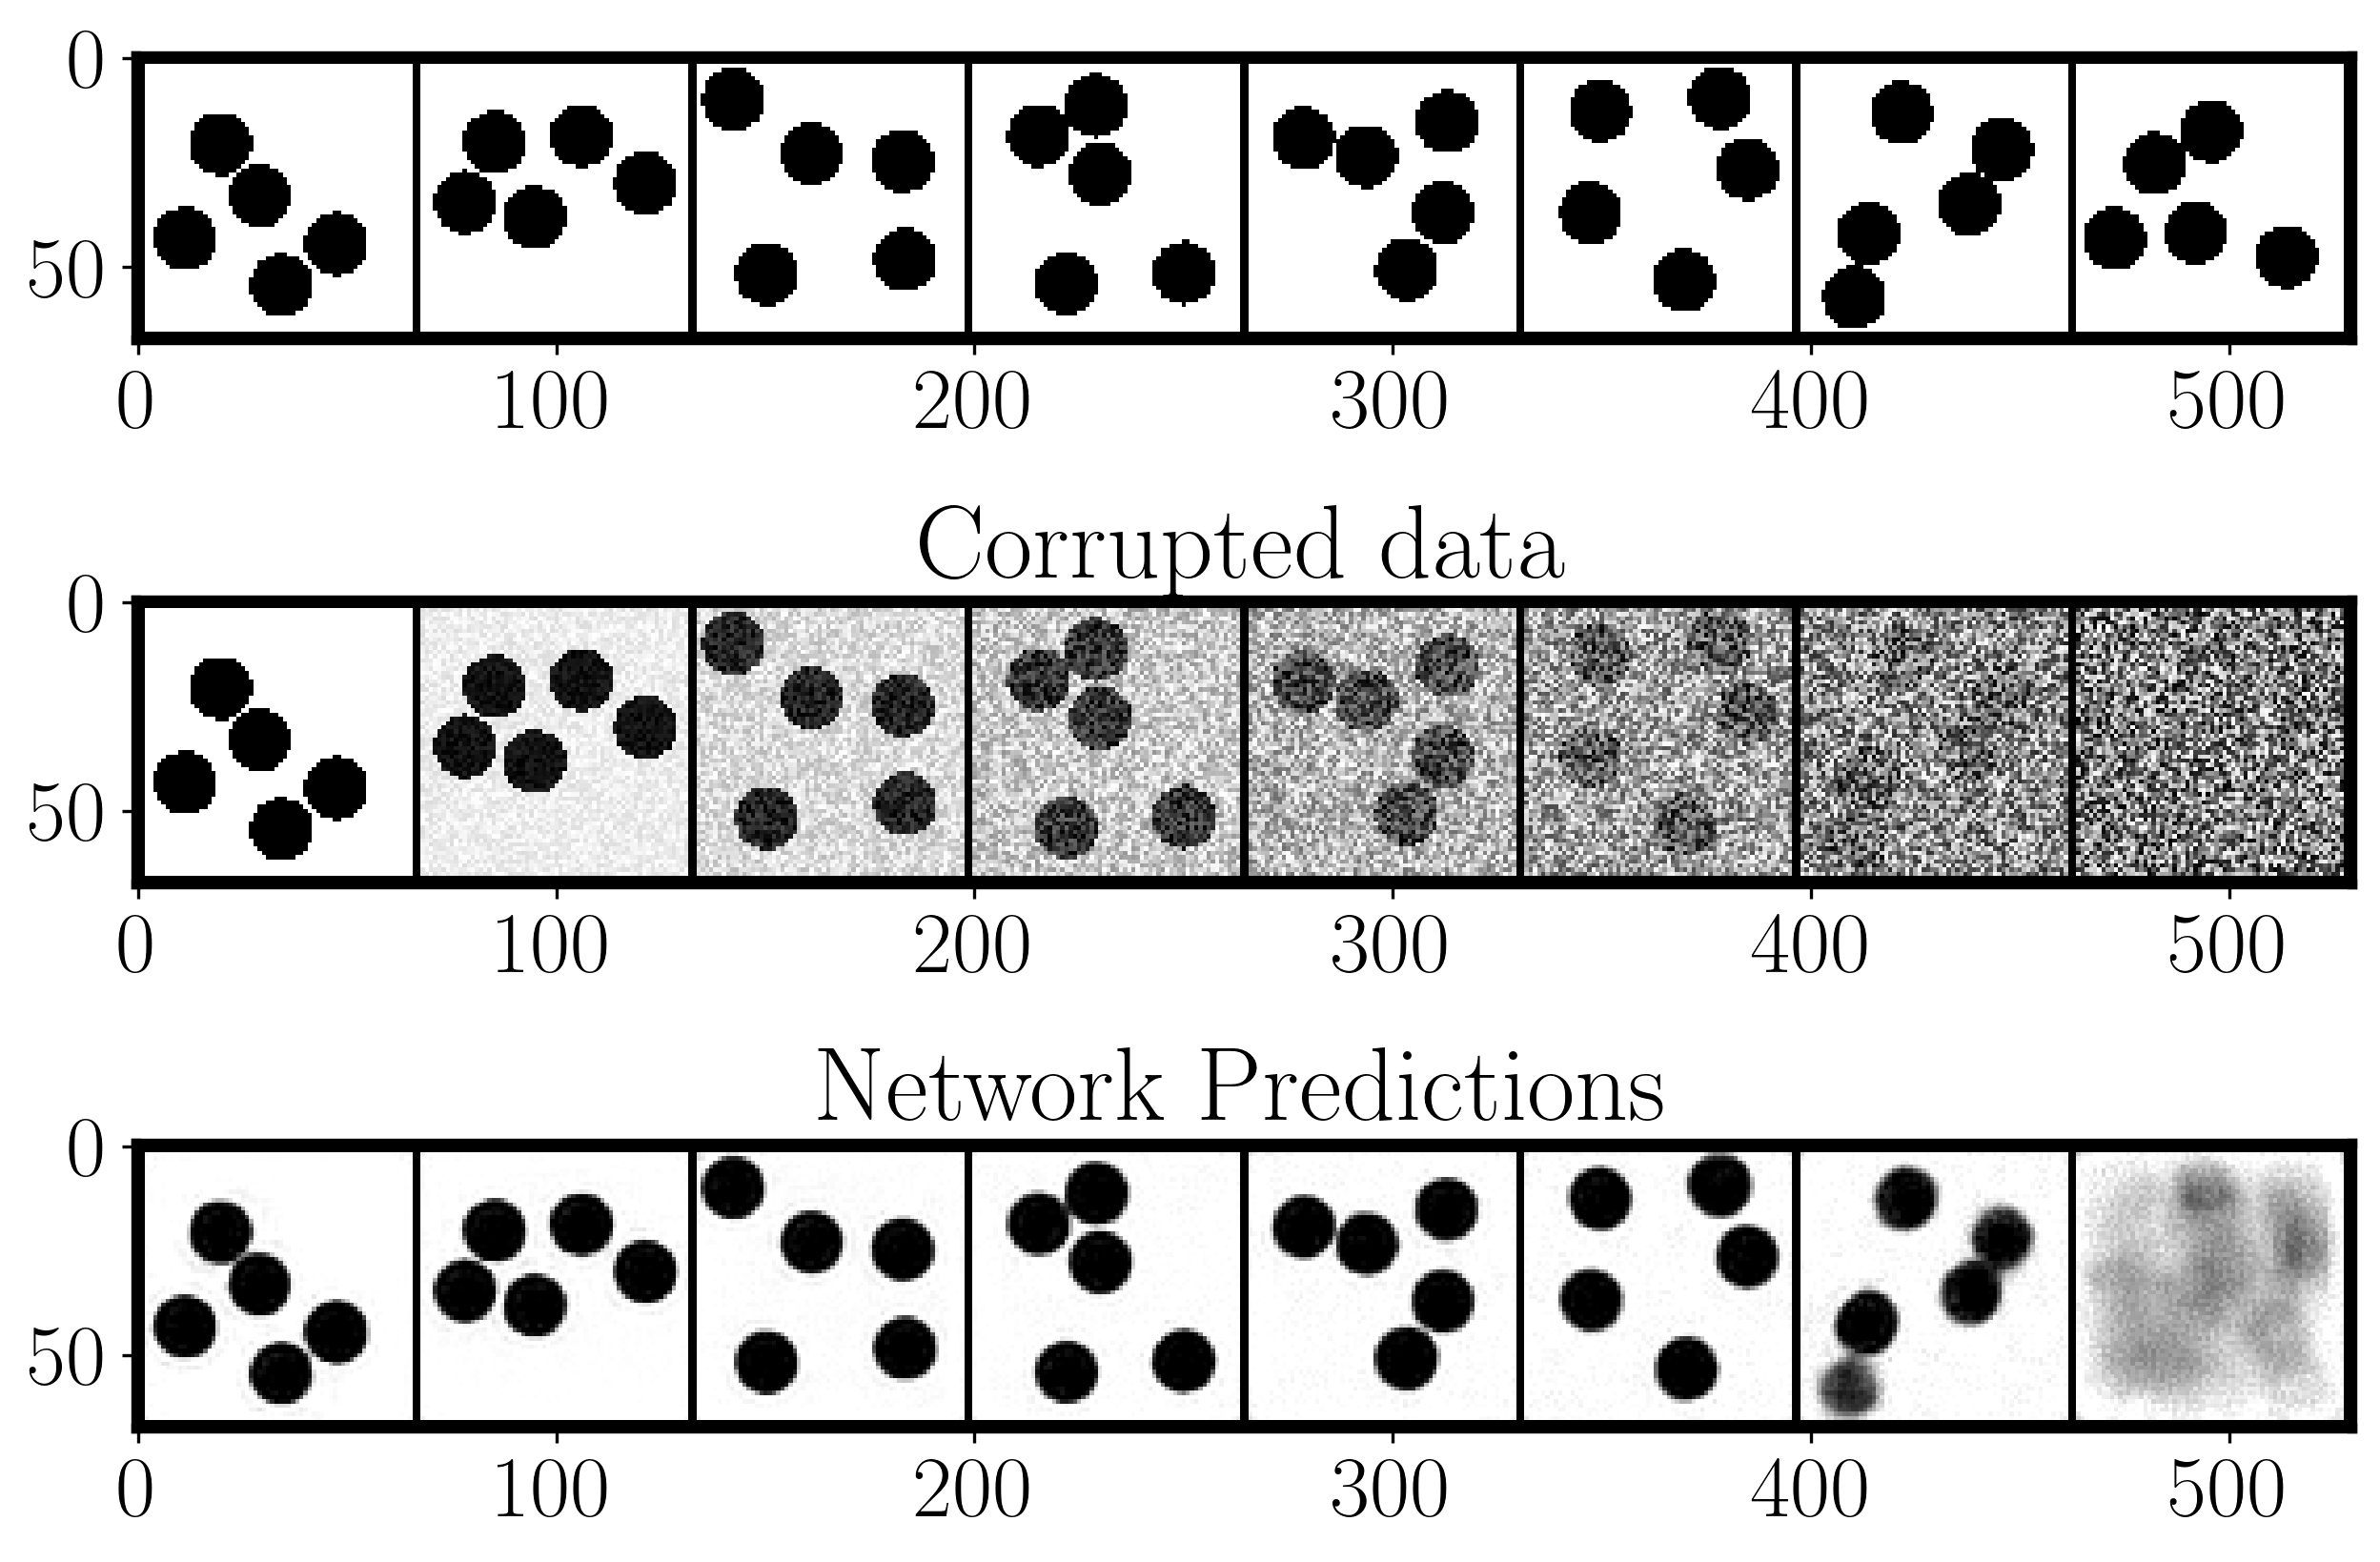

In [12]:
#@markdown Visualizing model predictions on noisy inputs:

# Fetch some data
x, y = next(iter(train_dataloader))
x = x[:8] # Only using the first 8 for easy plotting

# Corrupt with a range of amounts
amount = torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Get the model predictions
with torch.no_grad():
  preds = net(noised_x.to(device)).detach().cpu()

# Plot
fig, axs = plt.subplots(3,1,figsize=(10, 7))
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0, 1), cmap='gray')
axs[1].set_title('Corrupted data')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0, 1), cmap='gray')
axs[2].set_title('Network Predictions')
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1), cmap='gray')
plt.savefig('outputs/diffusion/predictions.png')
plt.show()


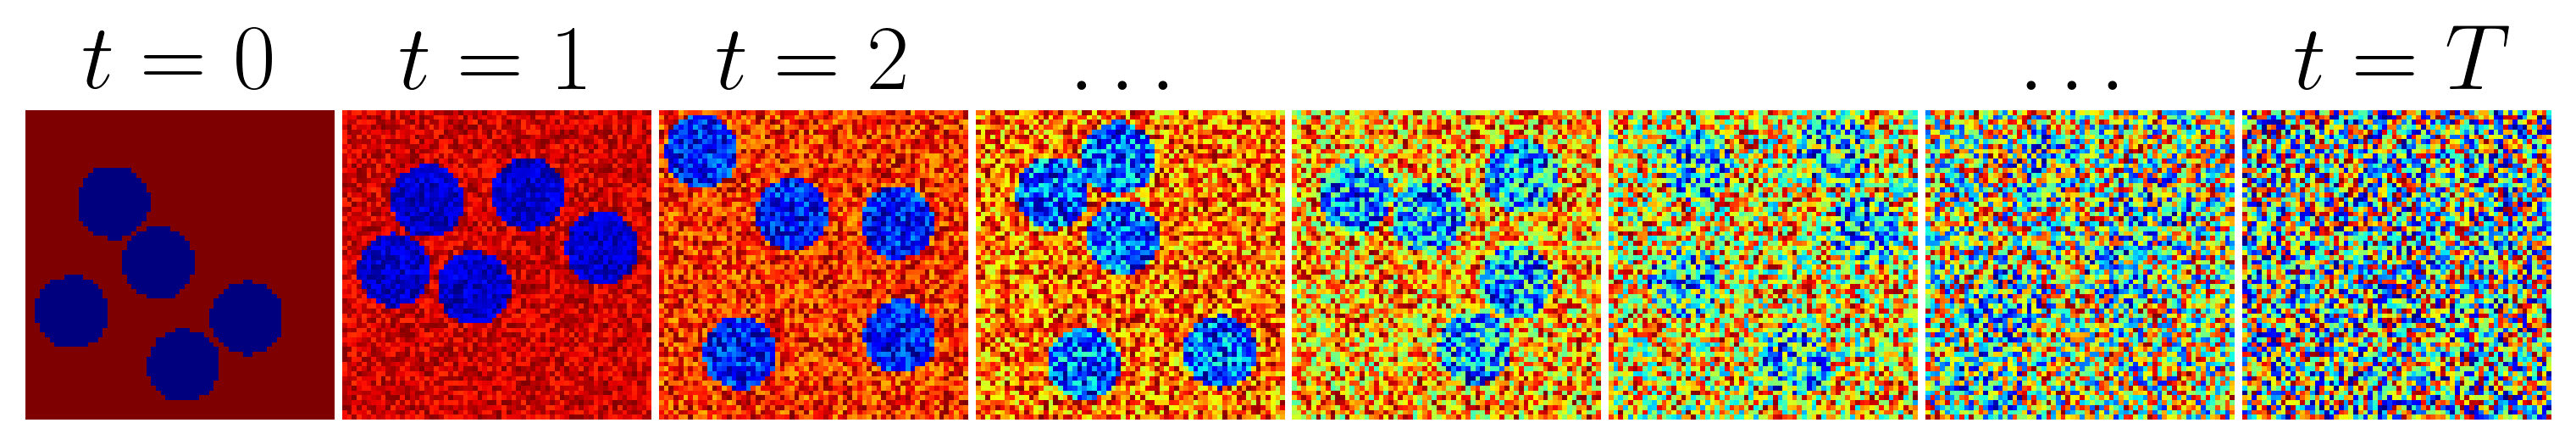

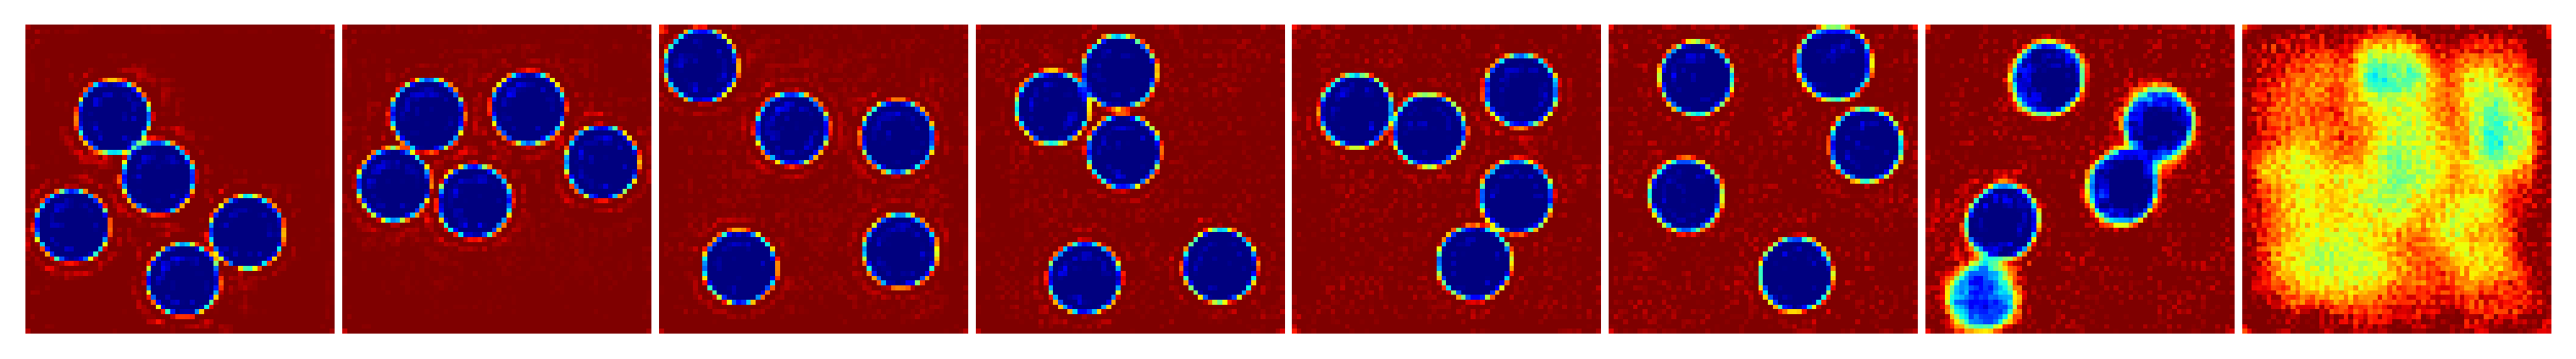

In [13]:
fig, axes = plt.subplots(1, 8, figsize=(10, 2))

for i in range(8):
    axes[i].imshow(noised_x[i][0], cmap='jet')
    axes[i].axis('off')

    # axes[i].set_title(f'$t = {t_labels[i]}$')

axes[0].set_title(r'$t = 0$')
axes[1].set_title(r'$t = 1$')
axes[2].set_title(r'$t = 2$')
axes[3].set_title(r'$\dots$')
axes[6].set_title(r'$\dots$')
axes[7].set_title(r'$t = T$')

# ax.set_rasterized(True)
plt.tight_layout(pad=0.1)
plt.savefig('outputs/diffusion/noisy_samples.pdf', bbox_inches='tight')
plt.savefig('outputs/diffusion/noisy_samples.pdf', bbox_inches='tight')
plt.show()


# Get the model predictions
with torch.no_grad():
  preds = net(noised_x.to(device)).detach().cpu()

fig, axes = plt.subplots(1, 8, figsize=(10, 2))

for i in range(8):
    axes[i].imshow(preds[i][0], cmap='jet', vmin=0, vmax=1)
    axes[i].axis('off')

plt.tight_layout(pad=0.1)
plt.savefig('outputs/diffusion/noisy_samples_predictions.pdf', bbox_inches='tight')
plt.savefig('outputs/diffusion/noisy_samples_predictions.pdf', bbox_inches='tight')
plt.show()


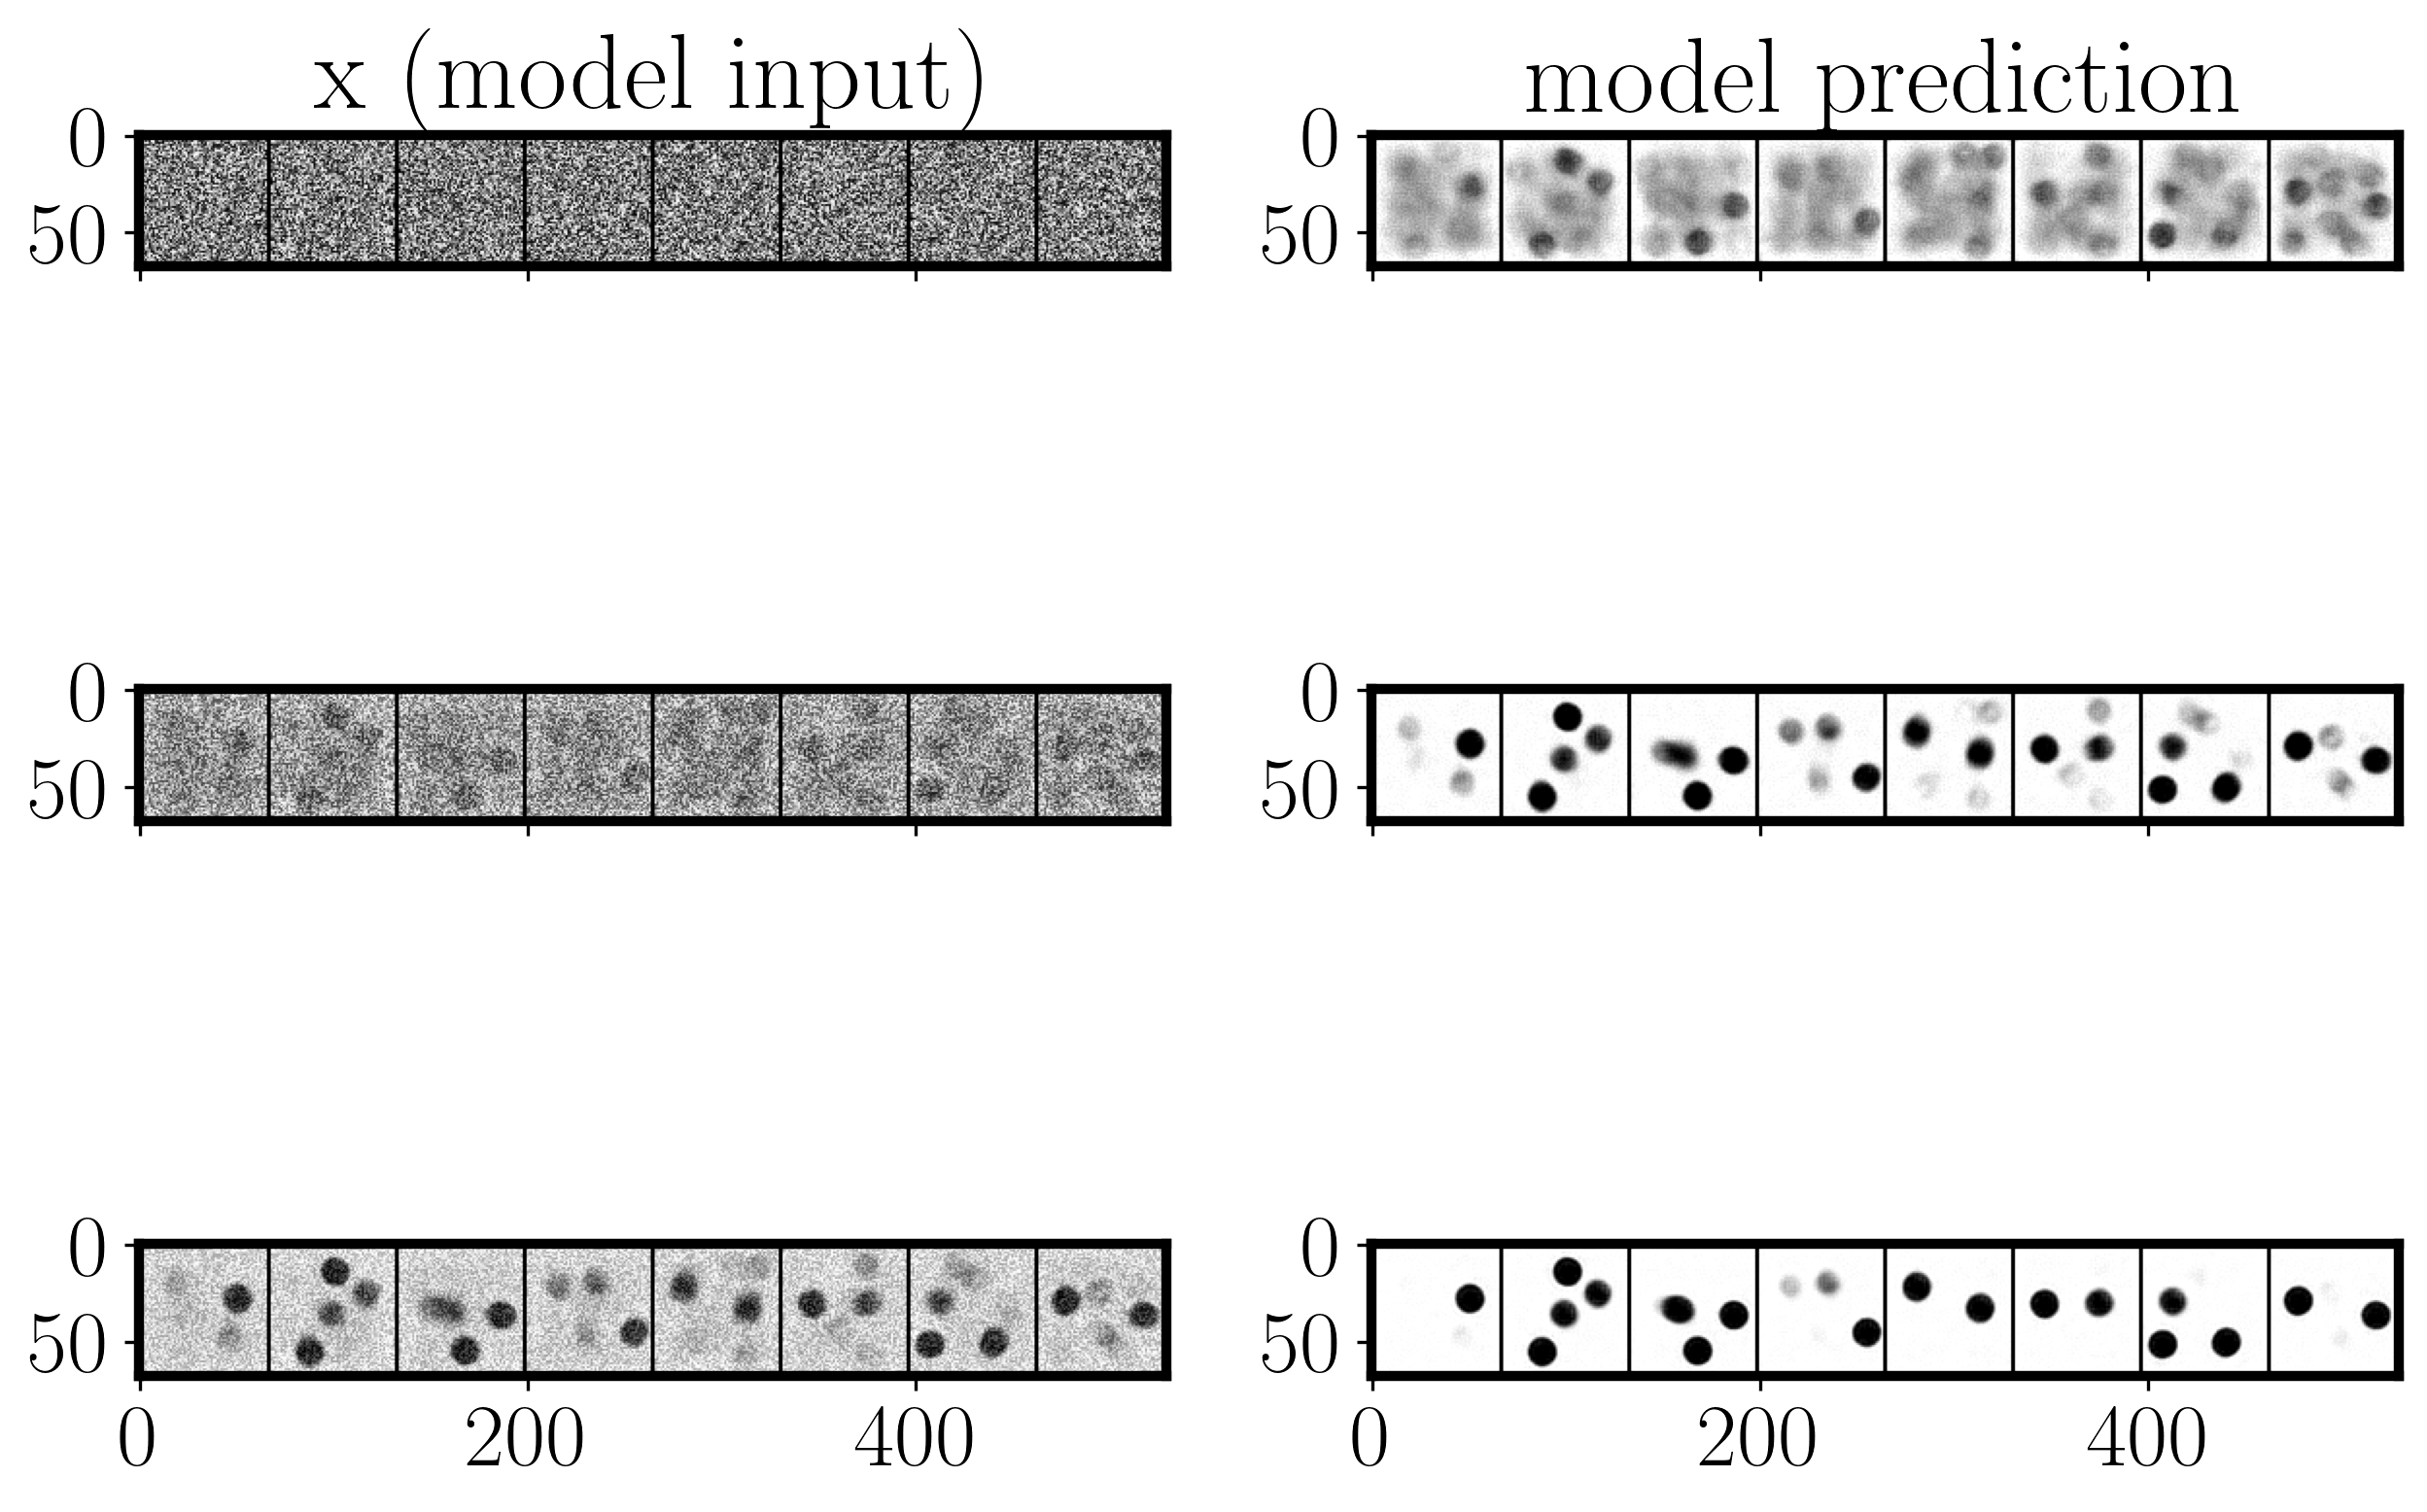

In [14]:
#@markdown Sampling strategy: Break the process into 5 steps and move 1/5'th of the way there each time:
n_steps = 3
x = torch.rand(8, 1, N, N).to(device) # Start from random
step_history = [x.detach().cpu()]
pred_output_history = []

for i in range(n_steps):
    with torch.no_grad(): # No need to track gradients during inference
        pred = net(x) # Predict the denoised x0
    pred_output_history.append(pred.detach().cpu()) # Store model output for plotting
    mix_factor = 1/(n_steps - i) # How much we move towards the prediction
    x = x*(1-mix_factor) + pred*mix_factor # Move part of the way there
    step_history.append(x.detach().cpu()) # Store step for plotting

fig, axs = plt.subplots(n_steps, 2, figsize=(10, 7), sharex=True)
axs[0,0].set_title('x (model input)')
axs[0,1].set_title('model prediction')
for i in range(n_steps):
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap='gray')
    axs[i, 1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1), cmap='gray')
plt.savefig(f'outputs/diffusion/sampling_{n_steps}_steps.png')
plt.show()


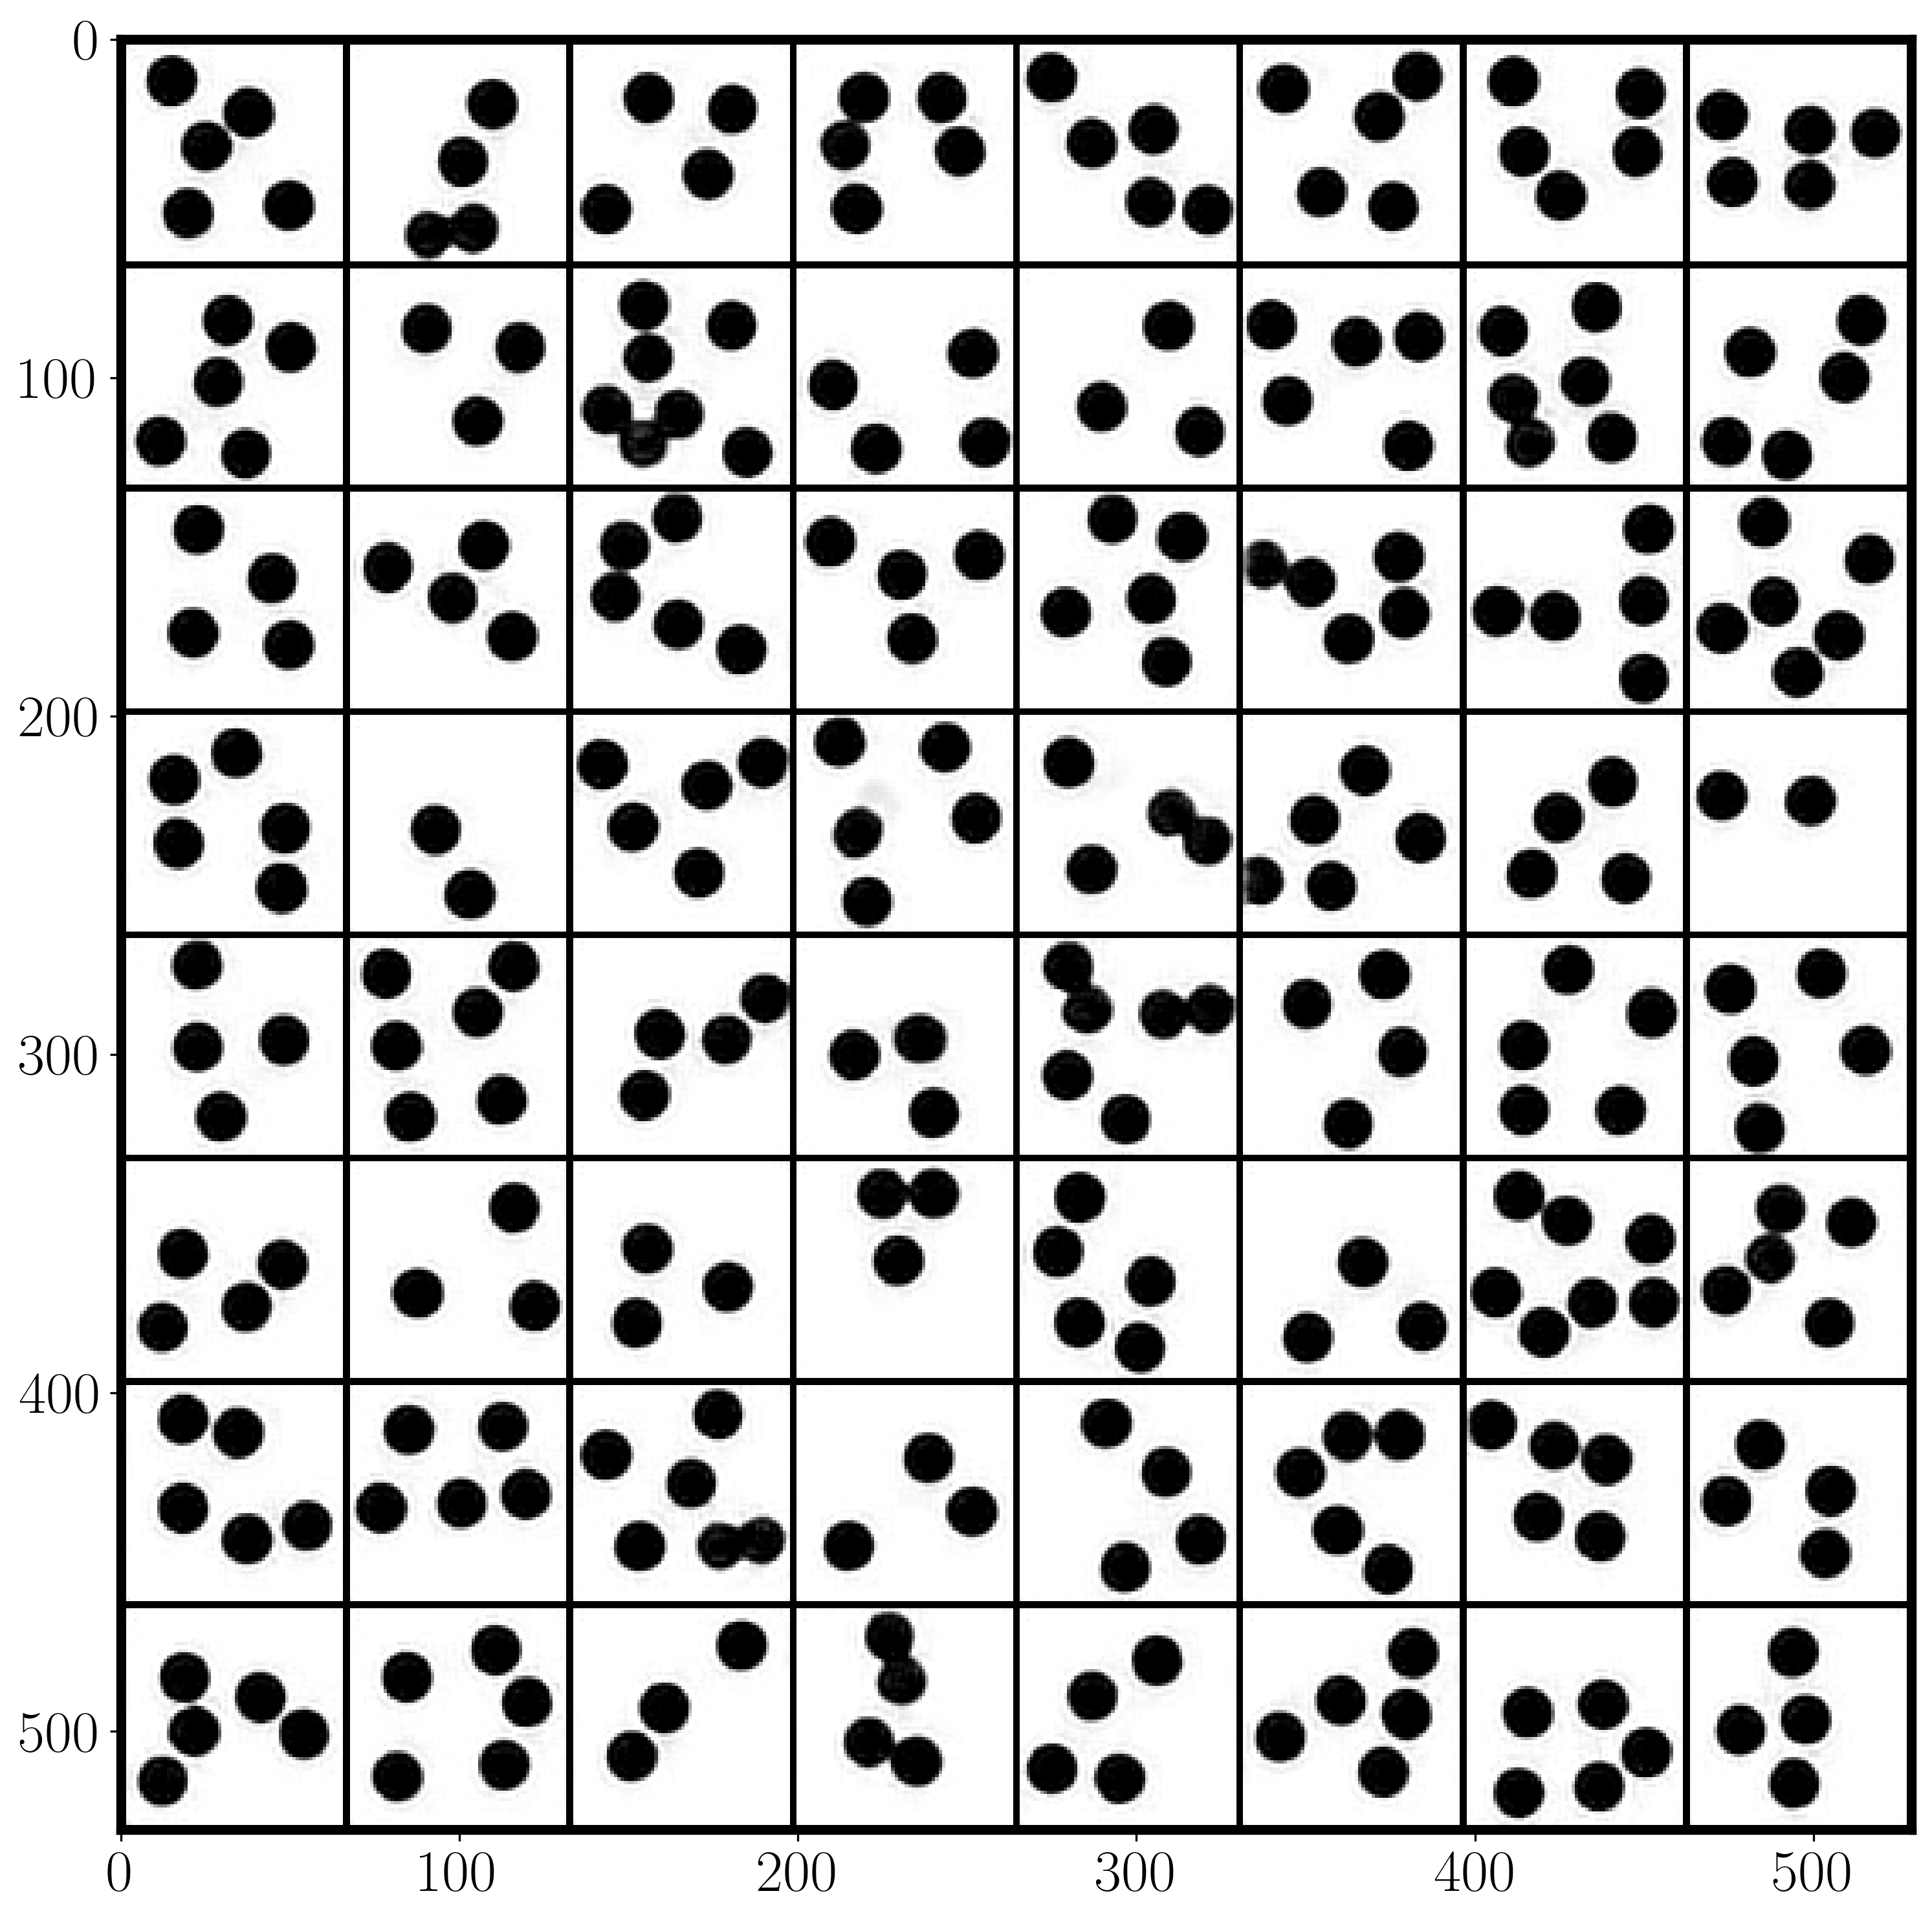

In [15]:
#@markdown Showing more results, using 40 sampling steps
n_steps = 40
x = torch.rand(64, 1, N, N).to(device)
for i in range(n_steps):
  noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps)) # Starting high going low
  with torch.no_grad():
    pred = net(x)
  mix_factor = 1/(n_steps - i)
  x = x*(1-mix_factor) + pred*mix_factor
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='gray')
plt.savefig(f'outputs/diffusion/sampling_{n_steps}_steps.png')
plt.show()



# Additional improvements

In [16]:
# model = UNet2DModel(
#     sample_size=28,           # the target image resolution
#     in_channels=1,            # the number of input channels, 3 for RGB images
#     out_channels=1,           # the number of output channels
#     layers_per_block=2,       # how many ResNet layers to use per UNet block
#     block_out_channels=(32, 64, 64), # Roughly matching our basic unet example
#     down_block_types=(
#         "DownBlock2D",        # a regular ResNet downsampling block
#         "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
#         "AttnDownBlock2D",
#     ),
#     up_block_types=(
#         "AttnUpBlock2D",
#         "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
#         "UpBlock2D",          # a regular ResNet upsampling block
#       ),
# )
# print(model)

# # %% [markdown]
# # As you can see, a little more going on! It also has significantly more parameters than our BasicUNet:

# # %%
# sum([p.numel() for p in model.parameters()]) # 1.7M vs the ~309k parameters of the BasicUNet

# # %% [markdown]
# # We can replicate the training shown above using this model in place of our original one. We need to pass both x and timestep to the model (here I always pass t=0 to show that it works without this timestep conditioning and to keep the sampling code easy, but you can also try feeding in `(amount*1000)` to get a timestep equivalent from the corruption amount). Lines changed are shown with `#<<<` if you want to inspect the code.

# # %%
# #@markdown Trying UNet2DModel instead of BasicUNet:

# # Dataloader (you can mess with batch size)
# batch_size = 128
# train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# # How many runs through the data should we do?
# n_epochs = 3

# # Create the network
# net = UNet2DModel(
#     sample_size=28,  # the target image resolution
#     in_channels=1,  # the number of input channels, 3 for RGB images
#     out_channels=1,  # the number of output channels
#     layers_per_block=2,  # how many ResNet layers to use per UNet block
#     block_out_channels=(32, 64, 64),  # Roughly matching our basic unet example
#     down_block_types=(
#         "DownBlock2D",  # a regular ResNet downsampling block
#         "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
#         "AttnDownBlock2D",
#     ),
#     up_block_types=(
#         "AttnUpBlock2D",
#         "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
#         "UpBlock2D",   # a regular ResNet upsampling block
#       ),
# ) #<<<
# net.to(device)

# # Our loss finction
# loss_fn = nn.MSELoss()

# # The optimizer
# opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# # Keeping a record of the losses for later viewing
# losses = []

# # The training loop
# for epoch in range(n_epochs):

#     for x, y in train_dataloader:

#         # Get some data and prepare the corrupted version
#         x = x.to(device) # Data on the GPU
#         noise_amount = torch.rand(x.shape[0]).to(device) # Pick random noise amounts
#         noisy_x = corrupt(x, noise_amount) # Create our noisy x

#         # Get the model prediction
#         pred = net(noisy_x, 0).sample #<<< Using timestep 0 always, adding .sample

#         # Calculate the loss
#         loss = loss_fn(pred, x) # How close is the output to the true 'clean' x?

#         # Backprop and update the params:
#         opt.zero_grad()
#         loss.backward()
#         opt.step()

#         # Store the loss for later
#         losses.append(loss.item())

#     # Print our the average of the loss values for this epoch:
#     avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
#     print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

# # Plot losses and some samples
# fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# # Losses
# axs[0].plot(losses)
# axs[0].set_ylim(0, 0.1)
# axs[0].set_title('Loss over time')

# # Samples
# n_steps = 40
# x = torch.rand(64, 1, 28, 28).to(device)
# for i in range(n_steps):
#   noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps)) # Starting high going low
#   with torch.no_grad():
#     pred = net(x, 0).sample
#   mix_factor = 1/(n_steps - i)
#   x = x*(1-mix_factor) + pred*mix_factor

# axs[1].imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='gray')
# axs[1].set_title('Generated Samples');

# # %%
# #??noise_scheduler.add_noise

# # %%
# noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
# plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
# plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
# plt.legend(fontsize="x-large");

# # %%
# #@markdown visualize the DDPM noising process for different timesteps:

# # Noise a batch of images to view the effect
# fig, axs = plt.subplots(3, 1, figsize=(16, 10))
# xb, yb = next(iter(train_dataloader))
# xb = xb.to(device)[:8]
# xb = xb * 2. - 1. # Map to (-1, 1)
# print('X shape', xb.shape)

# # Show clean inputs
# axs[0].imshow(torchvision.utils.make_grid(xb[:8])[0].detach().cpu(), cmap='gray')
# axs[0].set_title('Clean X')

# # Add noise with scheduler
# timesteps = torch.linspace(0, 999, 8).long().to(device)
# noise = torch.randn_like(xb) # << NB: randn not rand
# noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
# print('Noisy X shape', noisy_xb.shape)

# # Show noisy version (with and without clipping)
# axs[1].imshow(torchvision.utils.make_grid(noisy_xb[:8])[0].detach().cpu().clip(-1, 1),  cmap='gray')
# axs[1].set_title('Noisy X (clipped to (-1, 1)')
# axs[2].imshow(torchvision.utils.make_grid(noisy_xb[:8])[0].detach().cpu(),  cmap='gray')
# axs[2].set_title('Noisy X');


